In [1]:
import enum
import pandas as pd 
import os

import pyspark.sql.functions as F
from pyspark.sql.types import *
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import Row
import pyarrow.parquet as pq
import pyarrow as pa
import glob


import sys

import matplotlib.pyplot as plt
sys.setrecursionlimit(10000)

import re
import time
from bs4 import BeautifulSoup
sys.path.append("/scratch/venia/web2wiki/code/helpers/")


from settings import WIKI_PAGES_DIR

os.environ['SPARK_HOME'] = "/home/veselovs/spark-3.2.1-bin-hadoop2.7"
# os.environ['JAVA_HOME'] = "/home/veselovs/jdk-13.0.2"
spark = SparkSession.builder.getOrCreate()


22/11/12 12:57:20 WARN Utils: Your hostname, iccluster039 resolves to a loopback address: 127.0.1.1; using 10.90.38.15 instead (on interface ens786f0)
22/11/12 12:57:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/11/12 12:57:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/11/12 12:57:21 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/11/12 12:57:23 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [36]:
df2 = pd.read_parquet("/scratch/venia/web2wiki/data/test/santized-er_wiki.parquet")

In [24]:
order_0 = ["tag_footer", "tag_header","class_footer","class_header","class_sidebar"]


,url,href,tag_footer,tag_header,tag_sup,class_footer,class_header,class_sidebar,class_response,is_wiki,is_blog,header_reference,attribution
0,http://0-blogs.biomedcentral.com.brum.beds.ac....,http://en.wikipedia.org/wiki/Oleg_Atkov,0,0,0,0,0,0,0,0,1,0,0
1,http://0-blogs.biomedcentral.com.brum.beds.ac....,http://en.wikipedia.org/wiki/Latrodectus_hesperus,0,0,0,0,0,0,0,0,1,0,0
2,http://007software.net/tag/bug,https://en.wikipedia.org/wiki/Hacking_Team,0,0,0,0,0,0,0,0,0,0,0
3,http://007software.net/tag/guest-article,https://en.wikipedia.org/wiki/Back_Orifice_2000,0,0,0,0,0,0,0,0,0,0,0
4,http://00bien.tripod.com/id15.html,http://en.wikipedia.org/wiki/Edward_Bingham,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21597071,http://zywienie.abczdrowie.pl/jedzenie-wspiera...,http://en.wikipedia.org/wiki/Flax#mediaviewer/...,0,0,0,0,0,0,0,0,0,0,1
21597072,http://zzamboni.org/post/my-doom-emacs-configu...,https://en.wikipedia.org/wiki/Literate%5Fprogr...,0,0,0,0,0,0,0,0,0,0,0
21597073,http://zzzauber.wordpress.com/category/tauschu...,https://en.wikipedia.org/wiki/Kokichi_Sugihara,0,0,0,0,0,0,0,0,0,0,0
21597074,http://zzzinc.net/tag/bits,http://en.wikipedia.org/wiki/William_J._Mitchell,0,0,0,0,0,0,0,0,0,0,0


In [32]:
18194929 / (2644785 + 18194929 + 757362)

0.842471869803116

In [58]:
df = pd.read_csv("/scratch/venia/web2wiki/data/validation/first_order.csv")

/tmp/ipykernel_1088304/686039256.py:1: DtypeWarning: Columns (0,11,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/scratch/venia/web2wiki/data/validation/first_order.csv")


In [41]:
df3 = pd.read_csv("/scratch/venia/web2wiki/data/validation/across_orders.csv")

/tmp/ipykernel_1088304/2303648928.py:1: DtypeWarning: Columns (11,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv("/scratch/venia/web2wiki/data/validation/across_orders.csv")


In [57]:
df.sample()

,Unnamed: 0,url,href,tag_footer,tag_header,tag_sup,class_footer,class_header,class_sidebar,class_response,...,is_blog,header_reference,attribution,0th_order,evidence,2nd_order,order,domain,domain_count,first_class
0,0,http://0-blogs.biomedcentral.com.brum.beds.ac....,http://en.wikipedia.org/wiki/Oleg_Atkov,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0.0,0,0.0,0.0,0.0,1.0,0-blogs.biomedcentral.com.brum.beds.ac.uk,116.0,ws
1,1,http://0-blogs.biomedcentral.com.brum.beds.ac....,http://en.wikipedia.org/wiki/Latrodectus_hesperus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0.0,0,0.0,0.0,0.0,1.0,0-blogs.biomedcentral.com.brum.beds.ac.uk,116.0,ws
2,2,http://007software.net/tag/bug,https://en.wikipedia.org/wiki/Hacking_Team,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0,0.0,0.0,0.0,1.0,007software.net,9.0,ws
3,3,http://007software.net/tag/guest-article,https://en.wikipedia.org/wiki/Back_Orifice_2000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0,0.0,0.0,0.0,1.0,007software.net,9.0,ws
4,4,http://00bien.tripod.com/id15.html,http://en.wikipedia.org/wiki/Edward_Bingham,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0,0.0,0.0,0.0,1.0,00bien.tripod.com,125.0,ws
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18199383,21597071.0,http://zywienie.abczdrowie.pl/jedzenie-wspiera...,http://en.wikipedia.org/wiki/Flax#mediaviewer/...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,attribution,0.0,0.0,0.0,1.0,zywienie.abczdrowie.pl,10.0,attribution
18199384,21597072.0,http://zzamboni.org/post/my-doom-emacs-configu...,https://en.wikipedia.org/wiki/Literate%5Fprogr...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,1.0,zzamboni.org,3.0,ws
18199385,21597073.0,http://zzzauber.wordpress.com/category/tauschu...,https://en.wikipedia.org/wiki/Kokichi_Sugihara,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,1.0,zzzauber.wordpress.com,7.0,ws
18199386,21597074.0,http://zzzinc.net/tag/bits,http://en.wikipedia.org/wiki/William_J._Mitchell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,1.0,zzzinc.net,6.0,ws


In [60]:
df.loc[(df["order"]==1) & (df["attribution"] == "attribution"),"first_class"] = "attribution"
df.loc[(df["order"]==1) & (df["evidence"] !=0),"first_class"] = "evidence"




In [62]:
df.columns


Index(['Unnamed: 0', 'url', 'href', 'tag_footer', 'tag_header', 'tag_sup',
       'class_footer', 'class_header', 'class_sidebar', 'class_response',
       'is_wiki', 'is_blog', 'header_reference', 'attribution', '0th_order',
       'evidence', '2nd_order', 'order', 'domain', 'domain_count',
       'first_class'],
      dtype='object')

In [61]:
df.to_csv("/scratch/venia/web2wiki/data/validation/first_order.csv")

In [56]:

279340 / (17528454+382341+279340)

0.01535667547272189

In [34]:
df2.loc[df2["2nd_order"]>0,"order"] = 2


In [26]:
order_0 = ["tag_footer", "tag_header","class_footer","class_header","class_sidebar"]

evidence = ["tag_sup","header_reference"]
order_2 = ["class_response"]

df2["0th_order"] = df2[order_0].astype(float).sum(axis = 1)
df2["evidence"] = df2[evidence].astype(float).sum(axis = 1)


df2["2nd_order"] = df2[order_2].astype(float).sum(axis = 1)
print("Checkpoint: 4")


df2["order"] = df2.apply(lambda x: 2 if x["2nd_order"]>0 else 0 if x["0th_order"]>0 else 1, axis=1)

df2["first_class"] = df2.apply(lambda x: None if x["order"] != 1 else "attribution" if x["attribution"] != 0 else "evidence" if x["evidence"] != 0 else "ws",axis =1)


# df = df.dropna(subset="href")
# df = df[df["wiki_links"].apply(lambda x: True if "http" in str(x) else False)]
    

Checkpoint: 4


KeyboardInterrupt: 

In [5]:

def process_headers(x):
    soup = BeautifulSoup(x,features="lxml")
    page_len = soup.find_all()[-1].sourcepos
    all_links = soup.find_all('a', {"href": re.compile(regex_search)})
    resp = []
    for elt in all_links:
        print(elt)
        resp.append(extract_header(elt, page_len))
    return resp

def process_distance(x):
    soup = BeautifulSoup(x,features="lxml")
    page_len = soup.find_all()[-1].sourcepos
    all_links = soup.find_all('a', {"href": re.compile(regex_search)})
    resp = []
    for elt in all_links:
        print(elt)
        resp.append(extract_distance(elt, page_len))
    return resp
    
def extract_header(elt, page_len):
    prev_header = elt.find_previous(re.compile('^h[1-6]$'))
    if (prev_header != None):
        if prev_header.parent == elt.parent.parent:
            prev_name = prev_header.text
        else:
            prev_name = "None"

    else:
        prev_name = "None"
        distance = "None"
    return prev_name



# process_headers = F.udf(process_headers, ArrayType(StringType()))
# process_distance = F.udf(process_distance, ArrayType(IntegerType()))


In [313]:
import numpy as np
files = glob.glob(WIKI_PAGES_DIR+"/*")
files = list(np.random.choice(files, 1))


In [320]:
df = spark.read.load(files)


In [321]:
df = df.withColumn("previous_header", process_headers(F.col("content")))
df = df.withColumn("previous_distance", process_distance(F.col("content")))


In [323]:
df = df.cache()

In [326]:
t = df.limit(10).toPandas()

In [350]:
t["content"].apply(process_headers)

<a href="https://en.wikipedia.org/wiki/Genus" title="Genus">genus</a>
<a href="https://en.wikipedia.org/wiki/Cortinarius" title="Cortinarius">Cortinarius</a>
<a href="https://en.wikipedia.org/wiki/Lamella_(mycology)" title="Lamella (mycology)">gills</a>
<a href="https://en.wikipedia.org/wiki/Pay-per-click" rel="noopener" target="_blank">PPC</a>
<a class="list-group-item" href="https://en.wikipedia.org/wiki/Isatis gaubae" target="_blank">维基英文</a>
<a class="list-group-item" href="https://en.wikipedia.org/wiki/Viola canina var. muhlenbergii" target="_blank">维基英文</a>
<a href="https://en.wikipedia.org/wiki/James_Boyd_White">James Boyd White</a>
<a href="http://en.wikipedia.org/" style="margin: 0px; padding: 0px; border: 0px; outline: 0px; font-weight: inherit; font-style: inherit; font-size: 10px; font-family: inherit; vertical-align: baseline; text-decoration: none; color: rgb(17, 112, 163);">Wikipedia</a>


0                                                   []
1                                                   []
2                                   [None, None, None]
3                                   [Buy Bing ads VCC]
4                                                   []
5                                               [None]
6                                               [None]
7                                                   []
8    [The vision(s) of humanity in the EU’s constit...
9                                               [None]
Name: content, dtype: object

In [367]:
pd.set_option('display.max_colwidth', None)


In [69]:
df = pd.read_csv("/scratch/venia/web2wiki/data/web_content/iterative_coding_sample/cleaner_data.csv")


In [66]:
dff.sample(20)

,url,wiki_links,is_tag_footer,is_tag_header,is_tag_aside,is_tag_nav,is_tag_sup,is_tag_cite,is_tag_p,is_tag_article,is_class_footer,is_class_header,is_class_sidebar,is_class_comment,previous_header,nbhd_text,is_wiki,is_blog
6604,http://www.pskreporter.de?call=OH1LXF&s_type=r...,https://en.wikipedia.org/wiki/Italy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,\n\n435\n\n2021-03-07\n\n13:13:28\n\n\n1h:36m\...,0,0
2642,http://musicdayz.com/Another-Day/18-01/1968,http://en.wikipedia.org/wiki/The_Monkees,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,\n1968\n\n\n [BREAK] The Monkees [BREAK] cont...,0,0
5,http://1homemnacidade.blogs.sapo.pt/135017.html,http://31daarmada.blogs.sapo.pt/,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,None,\n LEITURAS\n 2666 – Roberto Bolaño\n Agora e ...,0,1
7705,http://www.tomrafteryit.net/category/podcast/feed,http://www.pubsub.com/,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,None,"o the concepts of structured blogging, and the...",0,0
3738,http://recipesrandycooks.com/tag/culantro,http://www.google.com/search?sourceid=chrome&i...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Speaking of Comfort Food – Pho Ga,s by the way are the fun part of Pho! Usually ...,0,0
1562,http://glendoratrophy.com/city-industry-awards...,http://en.wikipedia.org/wiki/Acrylic_trophy,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,None,[BREAK] Acrylic Trophy Wikipedia [BREAK],0,0
2661,http://musicdayz.com/Another-Day/18-01/1968,http://en.wikipedia.org/wiki/Neil_Diamond,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,"\n1968\nIlene Berns, widow of recently decease...",0,0
6804,http://www.pskreporter.de?call=OH1LXF&s_type=r...,https://www.pskreporter.de/report/locator/KN98...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,\n\n\n [BREAK] \n\tUS4IBD [BREAK] \n\n,0,0
65,http://acollectionofprayers.com/2016/06/23/eve...,http://bcponline.org/DailyOffice/compline.html,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,None,nd guard us sleeping;\nthat awake we may watch...,0,1
3479,http://palamas.info/come-forth,http://en.wikipedia.org/wiki/Son_of_God,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,None,[BREAK] Print [BREAK] FacebookLinkedInTwitter...,0,0


In [501]:
df["previous_header"] = df["previous_header"].astype(str)

In [502]:
df["is_class_comment"]

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
240906    0.0
240907    0.0
240908    0.0
240909    0.0
240910    0.0
Name: is_class_comment, Length: 240911, dtype: object

In [503]:
df["is_reference"] = df["previous_header"].apply(lambda x: 1 if "reference" in x.lower() else 0)

In [504]:
order_0 = ["is_tag_footer", "is_tag_header","is_tag_aside","is_class_footer","is_class_header","is_class_sidebar"]
evidence = ["is_tag_sup","is_tag_cite","is_reference"]
order_2 = ["is_class_comment"]

In [505]:
df["0th_order"] = df[order_0].sum(axis = 1)
df["evidence"] = df[evidence].sum(axis = 1)
df["2nd_order"] = df[order_2].sum(axis = 1)

In [658]:
df = df[df["2nd_order"]!="None"]

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i] + 0.01, int(round(100*y[i],0)), ha = "center", fontsize = 12)

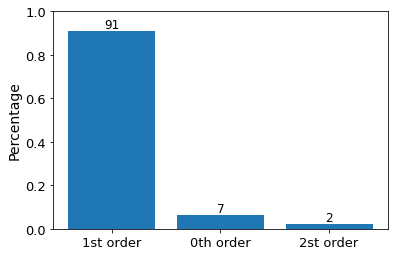

In [663]:
fig, ax = plt.subplots()
order_dist = df.groupby("order")["evidence"].count() /  df.groupby("order")["evidence"].count().sum()
order_dist.sort_values(ascending=False,inplace=True)
order_dist.index = ["0th order","1st order","2nd order"]
ax.bar(order_dist.index, order_dist.values)
ax.set_xticks([0,1,2])
ax.set_xticklabels(["1st order","0th order","2st order"])
addlabels(order_dist.index, order_dist.values)
ax.set_ylim(0,1)
ax.set_ylabel("Percentage",fontsize = 14)
# ax.set_xlabel("Order", fontsize = 14)
ax.tick_params(labelsize = 13)
plt.savefig("/scratch/venia/web2wiki/visuals/distribution_over_orders.pdf",dpi = 300, bbox_inches="tight")

In [664]:
first_order = df[df["order"] == 1]

In [507]:
df = df.fillna(0)

In [508]:
df["2nd_order"]=df["2nd_order"].astype(str)

In [509]:
df = df[df["2nd_order"].map(len) <4]

In [510]:
df["2nd_order"]=df["2nd_order"].astype(float)

In [511]:
df["order"] = df.apply(lambda x: 0 if x["0th_order"]>0 else 2 if x["2nd_order"]>0 else 1, axis=1)

In [682]:
first_order["attribution"]=first_order["wiki_links"].apply(lambda x: 1 if "File:" in x or "Image:" in x else 0)

/tmp/ipykernel_128953/3426052337.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_order["attribution"]=first_order["wiki_links"].apply(lambda x: 1 if "File:" in x or "Image:" in x else 0)


In [684]:
first_order["ws"] = first_order.apply(lambda x: 1 if (x["attribution"] == 0) & (x["evidence"] == 0) else 0,axis=1)

/tmp/ipykernel_128953/1006248081.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_order["ws"] = first_order.apply(lambda x: 1 if (x["attribution"] == 0) & (x["evidence"] == 0) else 0,axis=1)


In [686]:
melted= first_order[["attribution","evidence","ws"]].melt()

In [689]:
vals = melted[melted["value"] != 0]

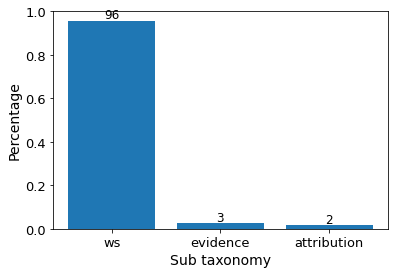

In [708]:
fig, ax = plt.subplots()
# vals = vals.groupby("variable")["value"].count() 
vals = vals / vals.sum()
# order_dist = df.groupby("order")["evidence"].count() /  df.groupby("order")["evidence"].count().sum()
vals.sort_values(ascending=False,inplace=True)
ax.bar(vals.index, vals.values)
# ax.set_xticks([0,1,2])
# ax.set_xticklabels(["1st order","0th order","2st order"])
addlabels(vals.index, vals.values)
ax.set_ylim(0,1)
ax.set_ylabel("Percentage",fontsize = 14)
ax.set_xlabel("Sub taxonomy", fontsize = 14)
ax.tick_params(labelsize = 13)
plt.savefig("/scratch/venia/web2wiki/visuals/distribution_over_first.pdf",dpi = 300, bbox_inches="tight")


In [614]:
df[df["evidence"] >0].groupby("order")["order"].count()

order
0     144
1    5891
Name: order, dtype: int64

df.groupby("order")["order"].count()

In [560]:
import tldextract
import urllib

def extract_subdomain(x):
    if len(tldextract.extract(x).subdomain) > 1:
        y = tldextract.extract(x).subdomain +"."+tldextract.extract(x).registered_domain
    else:
        y = tldextract.extract(x).registered_domain
    return y

def normalise_title(title):
    """ Replace _ with space, remove anchor, capitalize """
    title = title.split("/")[-1]
    title = title.split("#")[0]
    title = urllib.parse.unquote(title)
    title = title.strip()
    if len(title) > 0:
        title = title[0].upper() + title[1:]
    n_title = title.replace("_", " ")
    # if '#' in n_title:
    #     n_title = n_title.split('#')[0]
    return n_title

In [564]:
df

In [513]:
df["domain"] = df["url"].apply(lambda x: extract_subdomain(x))

In [517]:
df["domain_count"] = df.groupby("domain")["url"].transform("count")

In [568]:
dff = df[df["domain_count"]<1000]

In [593]:
dff = dff.drop_duplicates(subset = ["title","domain"])

In [569]:
# dff.groupby("order")["num_urls"].count()

In [594]:
t = dff.groupby(["order","title"])["url"].count().sort_values().reset_index()
t["total_count"] = t.groupby("order")["url"].transform("sum")

In [596]:
from scipy.stats import entropy

In [592]:
df[(df["order"] == 1) & (df["title"] == "Greasemonkey")].sample(20)

,url,wiki_links,is_tag_footer,is_tag_header,is_tag_aside,is_tag_nav,is_tag_sup,is_tag_cite,is_class_footer,is_class_header,...,is_wiki,is_blog,is_reference,0th_order,evidence,2nd_order,order,domain,domain_count,title
84188,http://www.flickriver.com/groups/_monster_high_appreciated_/pool/interesting,https://en.wikipedia.org/wiki/Greasemonkey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,1,www.flickriver.com,123,Greasemonkey
161924,http://flickriver.com/photos/184981954@N06/50859011721,https://en.wikipedia.org/wiki/Greasemonkey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,1,flickriver.com,105,Greasemonkey
65521,http://flickriver.com/photos/87777282@N00/285056629,https://en.wikipedia.org/wiki/Greasemonkey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,1,flickriver.com,105,Greasemonkey
133629,http://www.flickriver.com/groups/57998285@N00/pool/interesting,https://en.wikipedia.org/wiki/Greasemonkey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,1,www.flickriver.com,123,Greasemonkey
190511,http://flickriver.com/photos/kai2009/46625804905,https://en.wikipedia.org/wiki/Greasemonkey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,1,flickriver.com,105,Greasemonkey
237148,http://www.flickriver.com/photos/tags/%D7%99%D7%A6%D7%99%D7%A8%D7%95%D7%AA/interesting,https://en.wikipedia.org/wiki/Greasemonkey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,1,www.flickriver.com,123,Greasemonkey
134079,http://flickriver.com/photos/dierktopp/tags/moon,https://en.wikipedia.org/wiki/Greasemonkey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,1,flickriver.com,105,Greasemonkey
8848,http://www.flickriver.com/photos/185927310@N06/tags/phantom,https://en.wikipedia.org/wiki/Greasemonkey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,1,www.flickriver.com,123,Greasemonkey
123548,http://www.flickriver.com/photos/bensan94/50839380523,https://en.wikipedia.org/wiki/Greasemonkey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,1,www.flickriver.com,123,Greasemonkey
36066,http://www.flickriver.com/photos/184606191@N05/popular-interesting,https://en.wikipedia.org/wiki/Greasemonkey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,1,www.flickriver.com,123,Greasemonkey


In [597]:
t["p"] = t["url"] / t["total_count"]
zero = t[t["order"] == 0]
one = t[t["order"] == 1]
two = t[t["order"] == 2]

In [599]:

entropy(zero.sample(len(two))["p"])

7.982040639613382

In [600]:
entropy(one.sample(len(two))["p"])

7.957081090155766

In [601]:
entropy(two["p"])

8.090034027215543

In [603]:
t[t["order"] == 0].sort_values(by = "p",ascending=False).head(30)

,order,title,url,total_count,p
115930,0,HTTP cookie,45,5658,0.007953
115929,0,Taxicab,45,5658,0.007953
115920,0,Wikipedia:Text of Creative Commons Attribution-ShareAlike 3.0 Unported License,38,5658,0.006716
115919,0,Main Page,37,5658,0.006539
115901,0,,26,5658,0.004595
115885,0,Open access,22,5658,0.003888
115882,0,Wikipedia:Contact us,22,5658,0.003888
115859,0,Electrician,19,5658,0.003358
115820,0,Real estate broker,16,5658,0.002828
115758,0,Techengage,13,5658,0.002298


In [467]:
df["num_urls"] = df.groupby("url")["wiki_links"].transform("count")

/tmp/ipykernel_128953/111772763.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["num_urls"] = df.groupby("url")["wiki_links"].transform("count")


In [477]:
df[df["evidence"] > 0].sample(30)

,url,wiki_links,is_tag_footer,is_tag_header,is_tag_aside,is_tag_nav,is_tag_sup,is_tag_cite,is_class_footer,is_class_header,...,is_class_comment,previous_header,is_wiki,is_blog,is_reference,0th_order,evidence,2nd_order,order,num_urls
51535,http://slife.org/consciousness,https://en.wikipedia.org/wiki/Owen_Flanagan,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,None,0.0,0.0,0,0.0,1.0,0.0,1,329
136331,http://www.eclectecon.net/2015/02,https://en.wikipedia.org/wiki/Aquaculture_in_Chile#cite_note-econo-2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,None,0.0,1.0,0,0.0,1.0,0.0,1,18
4032,http://www.cre8noh8.org/us-government/team-trump/russiagate/paul-manafort,"https://en.wikipedia.org/wiki/Black,_Manafort,_Stone_and_Kelly#cite_note-4",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,"Black, Manafort, Stone and Kelly a.k.a. The Torturer’s Lobby",0.0,0.0,0,0.0,1.0,0.0,1,61
2847,http://fullautoexperience.com/hk-mp5k-suppressed-in-9mm-50-rounds-included,https://en.wikipedia.org/wiki/Heckler_%26_Koch_MP5#cite_note-FOOTNOTEDockery3007220-5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,None,0.0,0.0,0,0.0,1.0,0.0,1,13
45205,http://skrbh.wordpress.com/tag/tschus,https://en.wikipedia.org/wiki/Vladimir_Dybo,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,None,0.0,0.0,0,0.0,1.0,0.0,1,38
55528,http://slife.org/relativism,https://en.wikipedia.org/wiki/Donald_Brown_(anthropologist),0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,None,0.0,0.0,0,0.0,1.0,0.0,1,21
189293,http://ru-wiki.ru/wiki/%D0%9C%D0%B0%D1%80%D1%81%D0%B8%D0%B0%D0%BD%D0%B8%D0%BD_(%D1%84%D0%B8%D0%BB%D1%8C%D0%BC),https://en.wikipedia.org/wiki/Ty_Burr,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,None,1.0,0.0,0,0.0,1.0,0.0,1,43
230995,http://www.eugine360.com/david-cameron,https://en.wikipedia.org/wiki/David_Cameron#cite_note-1992_conference-48,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,Special Adviser to the Chancellor,0.0,0.0,0,0.0,1.0,0.0,1,1099
180097,http://www.arkcode.com/custom3_423.html,https://en.wikipedia.org/wiki/Order_of_Friendship#cite_note-nez0401-8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,None,0.0,0.0,0,0.0,1.0,0.0,1,97
103895,http://ru-wiki.ru/wiki/%D0%A1%D0%BB%D0%BE%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5,https://en.wikipedia.org/wiki/Mathematical_table,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,None,1.0,0.0,0,0.0,1.0,0.0,1,24


In [298]:
df = df.drop(columns = "url")
df2 = df.apply(lambda x: x.apply(pd.Series).stack()).reset_index().drop('level_1', 1)


/tmp/ipykernel_128953/2125663884.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df2 = df.apply(lambda x: x.apply(pd.Series).stack()).reset_index().drop('level_1', 1)


In [302]:
df2

,level_0,wiki_links,is_tag_footer,is_tag_header,is_tag_aside,is_tag_nav,is_tag_sup,is_tag_cite,is_class_footer,is_class_header,is_class_sidebar,is_class_comment,previous_header
0,2,https://en.wikipedia.org/wiki/DNA_digital_data...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
1,3,http://en.wikipedia.org/wiki/2008_Summer_Olympics,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,None
2,4,http://en.wikipedia.org/wiki/Siheyuan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
3,4,http://en.wikipedia.org/wiki/2008_Summer_Olympics,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,None
4,5,http://en.wikipedia.org/wiki/2008_Summer_Olympics,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5010,2073,http://en.wikipedia.org/wiki/Allura_Red_AC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
5011,2073,http://en.wikipedia.org/wiki/Cochineal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
5012,2073,http://en.wikipedia.org/wiki/Allura_Red_AC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
5013,2073,http://en.wikipedia.org/wiki/Amaranth_(dye),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None


In [272]:
df[df["previous_header"].apply(lambda x: "Reference" in x[0])]["url"].iloc[4]

'http://dictionnaire.sensagent.leparisien.fr/World%20Weary/en-en'

In [251]:
df.sample(30)["previous_header"]

91                                                 [None]
737                                                [None]
390                                                [None]
550                                          [None, None]
782                                                [None]
1022                                               [None]
1262                                               [None]
1219                                   [None, None, None]
370                                                [None]
397                        [None, None, None, None, None]
23                                                 [None]
1858    [None, None, None, None, None, None, None, Non...
1305                                               [None]
752                                                [None]
1796    [None, None, None, None, None, None, None, Non...
118                                                [None]
29                                           [None, None]
1570          

In [22]:
import requests
t = requests.get("http://bobneilson.org/2013/02/27/the-lovechild-of-anne-of-green-gables-an-interview-with-kari-sperring").text

link = "https://sharetv.com/shows/jack_whitehall_travels_with_my_father"
# link = "https://docs.fileformat.com/email/tnef/"
t = requests.get(link).text

In [6]:
html_code = """
    <!DOCTYPE html>
    <html lang="en">
    <meta charset="UTF-8">
    <title>Page Title</title>
    <meta name="viewport" content="width=device-width,initial-scale=1">
    <link rel="stylesheet" href="">
    <style>
    </style>
    <script src=""></script>
    <body>

    <img src="img_la.jpg" alt="LA" style="width:100%">

    <h>HI<\h>

    <div class="">
     <h1>This is a Heading</h1>
     <p>This is a paragraph.</p>
     <p>This is another paragraph.</p>
    </div>

    </body>
    </html>
"""

In [23]:
bs = BeautifulSoup(t,'html.parser')

In [48]:
not_wiki = []
for link in not_wiki:
    b = all_links[0].find_previous(re.compile('^a$'))
    not_wiki.append(b)

In [62]:
import numpy as np
np.random.rand()

0.39220797757621373

In [24]:
all_links = bs.find_all('a', {"href": re.compile(regex_search)})


In [28]:

import lxml.html as LH
import itertools

def find_nearest(elt):
    preceding = elt.xpath('preceding::*/@href')[::-1]
    following = elt.xpath('following::*/@href')
    parent = elt.xpath('parent::*/@href')
    for href in roundrobin(parent, preceding, following):
        return href

def roundrobin(*iterables):
    "roundrobin('ABC', 'D', 'EF') --> A D E B F C"
    # http://docs.python.org/library/itertools.html#recipes
    # Author: George Sakkis
    pending = len(iterables)
    nexts = itertools.cycle(iter(it).next for it in iterables)
    while pending:
        try:
            for n in nexts:
                yield n()
        except StopIteration:
            pending -= 1
            nexts = itertools.cycle(itertools.islice(nexts, pending))
find_nearest(all_links[0])


TypeError: 'NoneType' object is not callable

In [ ]:
all_links[0].find_

In [32]:
all_links[0].xpath("*/@href")

TypeError: 'NoneType' object is not callable

In [31]:
all_links

[<a href="https://en.wikipedia.org/wiki/Jack_Whitehall:_Travels_with_My_Father" target="_blank">Wikipedia</a>]

In [26]:
bs.find_all()[0].find_previous((re.compile('^h[1-6]$')))  != None

False

In [ ]:
def extract_headers(elt):
    prev_header = elt.find_previous((re.compile('^h[1-6]$')))
    elt_pos = elt.sourcepos
    prev_name = prev_header.name
    prev_pos = prev_header.sourcepos 
    page_len = bs.find_all()[-1].sourcepos
    
    distance = (elt_pos - prev_pos) / page_len
    return (prev_name,distance)

In [253]:
all_links[0].find_previous(re.compile('^h[1-6]$'))

<h2 id="references">References <a class="header-link" href="#references"><svg class="fill-current o-60 hover-accent-color-light" height="22" viewbox="0 0 24 24" width="22" xmlns="http://www.w3.org/2000/svg"><path d="M0 0h24v24H0z" fill="none"></path><path d="M3.9 12c0-1.71 1.39-3.1 3.1-3.1h4V7H7c-2.76.0-5 2.24-5 5s2.24 5 5 5h4v-1.9H7c-1.71.0-3.1-1.39-3.1-3.1zM8 13h8v-2H8v2zm9-6h-4v1.9h4c1.71.0 3.1 1.39 3.1 3.1s-1.39 3.1-3.1 3.1h-4V17h4c2.76.0 5-2.24 5-5s-2.24-5-5-5z"></path></svg></a></h2>

In [218]:
all_links[0].sourcepos - all_links[0].find_previous(re.compile('^h[1-6]$')).sourcepos

484

In [ ]:
print(tag.sourceline, tag.sourcepos, tag.string)

In [126]:
all_links

[<a href="https://en.wikipedia.org/wiki/Transport_Neutral_Encapsulation_Format">Transport Neutral Encapsulation Format</a>]

In [ ]:
re.compile("references|bibliography|")

In [112]:
for elt in bs.find_all(re.compile('^h[1-6]$')):
    try:
        if "references" in elt.text.lower():
            print(elt.next_sibling.find_all('a', {"href": re.compile(regex_search)}))
#         print(elt)
    except:
        pass


[<a href="https://en.wikipedia.org/wiki/Transport_Neutral_Encapsulation_Format">Transport Neutral Encapsulation Format</a>]


In [124]:
bs.find_all(re.compile('^h[1-6]$'))[6]

<h2 id="references">References <a class="header-link" href="#references"><svg class="fill-current o-60 hover-accent-color-light" height="22" viewbox="0 0 24 24" width="22" xmlns="http://www.w3.org/2000/svg"><path d="M0 0h24v24H0z" fill="none"></path><path d="M3.9 12c0-1.71 1.39-3.1 3.1-3.1h4V7H7c-2.76.0-5 2.24-5 5s2.24 5 5 5h4v-1.9H7c-1.71.0-3.1-1.39-3.1-3.1zM8 13h8v-2H8v2zm9-6h-4v1.9h4c1.71.0 3.1 1.39 3.1 3.1s-1.39 3.1-3.1 3.1h-4V17h4c2.76.0 5-2.24 5-5s-2.24-5-5-5z"></path></svg></a></h2>

'references '

In [88]:
all_links[0].parent.parent.previous_sibling.previous_sibling.text

'\nRelated Links\nMore Links\n'

In [77]:
all_links[0].parent.previous_sibling.previous_sibling

<li><a href="http://www.tomwolfe.com/bio.html" rel="noopener noreferrer" target="_blank">Tom Wolfe’s website</a></li>

In [53]:
all_links

[<a href="http://en.wikipedia.org/wiki/Coventry" style="line-height:1.5;">Coventry</a>,
 <a href="http://en.wikipedia.org/wiki/Cambridge">Cambridge</a>]

In [34]:
re.findall(regex_search, t)[0]

"en.wikipedia.org/wiki/Valentine's_Day"

In [19]:
bs.text

'\n\n\n\nPage Title\n\n\n\n\n\n\nHI<\\h>\n\n    \nThis is a Heading\nThis is a paragraph.\nThis is another paragraph.\n\n\n\n'

In [3]:
files = glob.glob(WIKI_PAGES_DIR+"/*")[0:5]

NameError: name 'WIKI_PAGES_DIR' is not defined

In [ ]:
df = spark.read.load(files)


In [ ]:
df.take(10)

In [40]:
schema = StructType([
    StructField("a1", ArrayType(StringType()), False),
    StructField("a2", ArrayType(StringType()), False),
    StructField("wiki_url", ArrayType(StringType()), False),
    StructField("text1", ArrayType(StringType()),False),
    StructField("text2", ArrayType(StringType()), False)
])

In [6]:
regex_search = r"(en.wikipedia\.org[\s\/a-zA-ZäöüÄÖÜßþóúí\_\?(\),\,\-\#\&\$\@\!0-9\.\%\–\'\:\!]+)"

@F.udf
def extract_regex(x):
    links = re.findall(regex_search, x)
    return links

def extract_soup(x: str):
    soup = BeautifulSoup(x,features="lxml")
    all_links = soup.find_all('a', {"href": re.compile(regex_search)})
    
    k1 = []
    k2 = []
    p_texts1 = []
    p_texts2 = []
    
    k_name = []
    
    for a in all_links:
        if a.get("href") != None:
            
            parent = a.parent
            
            k1.append(str(parent.name))
            k2.append(str(parent.parent.name))
            if parent.name == "p":
                p_texts1.append(str(parent))
            else:
                p_texts1.append(None)
            if parent.parent.name == "p":
                p_texts2.append(str(parent.parent))
            else:
                p_texts2.append(None)

            k_name.append(a.get("href"))
    return [k1,k2, k_name, p_texts1, p_texts2]


extract_soup_udf = F.udf(extract_soup, schema)

NameError: name 'schema' is not defined

In [133]:
hey = df.select(extract_soup_udf(F.col("content")).alias("hi"))

In [134]:
hey.printSchema()

root
 |-- hi: struct (nullable = true)
 |    |-- a1: array (nullable = false)
 |    |    |-- element: string (containsNull = true)
 |    |-- a2: array (nullable = false)
 |    |    |-- element: string (containsNull = true)
 |    |-- wiki_url: array (nullable = false)
 |    |    |-- element: string (containsNull = true)
 |    |-- text1: array (nullable = false)
 |    |    |-- element: string (containsNull = true)
 |    |-- text2: array (nullable = false)
 |    |    |-- element: string (containsNull = true)



In [136]:
hey2 = hey.select(F.col("hi.a1").alias("a1"), F.col("hi.a2").alias("a2"),F.col("hi.wiki_url").alias("wiki_url"),F.col("hi.text1").alias("text1"), F.col("hi.text2").alias("text2")).filter(sf.size("hi.wiki_url") > 0)

In [137]:
hey3 = hey2.withColumn("new", F.arrays_zip("a1","a2","wiki_url","text1","text2"))

hey3 = hey3.withColumn("new",F.explode("new"))
hey3 = hey3.select(F.col("new.a1").alias("a1"), F.col("new.a2").alias("a2"), F.col("new.wiki_url").alias("wiki_url"), F.col("new.text1").alias("text1"), F.col("new.text2").alias("text2"))

In [138]:
test = hey3.toPandas()

In [140]:
test

,a1,a2,wiki_url,text1,text2
0,li,ul,http://en.wikipedia.org/wiki/Ukhta?oldid=53956...,None,None
1,li,ul,http://en.wikipedia.org/wiki/Ukhta,None,None
2,p,div,http://en.wikipedia.org/wiki/H Potter Decorati...,"<p>Click <a href=""http://en.wikipedia.org/wiki...",None
3,span,dd,http://en.wikipedia.org/wiki/[Anonym],None,None
4,p,div,http://en.wikipedia.org/wiki/Information_asymm...,"<p>The sort of <a href=""http://en.wikipedia.or...",None
...,...,...,...,...,...
6768,span,div,http://en.wikipedia.org/wiki/ISO_639-1,None,None
6769,li,ul,http://en.wikipedia.org/wiki/Parliament_of_New...,None,None
6770,span,div,http://en.wikipedia.org/wiki/ISO_639-1,None,None
6771,span,div,http://en.wikipedia.org/wiki/ISO_639-1,None,None


In [139]:
test.to_csv("~/text.csv")

In [198]:
# playground

sample = df.sample(100).content.values[0]

soup = BeautifulSoup(sample, features = "lxml")
all_links = soup.find_all('a', {"href": re.compile(regex_search)})

k = [[k.parent.name,k.parent.parent.name] for k in all_links]

paragraph_texts = []

for l in all_links:
    if l.parent.name == "p":
        paragraph_texts.append(l.parent)
    else:
        paragraph_texts.append(None)

In [247]:
t["html"], t["title"], t["p_text1"], t["p_text2"] = zip(*t["content"].map(extract_soup))

In [248]:
t = t.explode(["title", "html", "p_text1","p_text2"])

In [249]:
t = t.dropna(subset = "html")

In [250]:
t["c1"],t["c2"] = zip(*(t["html"]))

In [251]:
t.groupby(["c1"])["c2"].count().sort_values()

c1
dd         1
font       1
footer     1
main       1
h5         2
em         3
small      3
strong     3
h3         4
span       8
b          9
td         9
div       24
li        28
p         69
Name: c2, dtype: int64

In [254]:
t

,url,content,html,title,p_text1,p_text2,c1,c2
1012,http://top55.hu/blog/budapest/ix-9-kerulet/oldal/1,"<!DOCTYPE html><html lang=""en""><head><meta name=""viewport"" content=""width=device-width, initial-scale=1""><!-- Page Title --><title>Top55 Blog Budapest megye IX. 9. kerület</title><meta name=""keywords"" content=""Top55 Blog Budapest megye IX. 9. kerület""><meta name=""author"" content=""DesLandGroup""><meta name=""description"" content=""Top55 Blog Budapest megye IX. 9. kerület""><meta charset=""utf-8""><link rel=""apple-touch-icon"" sizes=""57x57"" href=""/public/pages/favicon/apple-icon-57x57.png""><link rel=""apple-touch-icon"" sizes=""60x60"" href=""/public/pages/favicon/apple-icon-60x60.png""><link rel=""apple-touch-icon"" sizes=""72x72"" href=""/public/pages/favicon/apple-icon-72x72.png""><link rel=""apple-touch-icon"" sizes=""76x76"" href=""/public/pages/favicon/apple-icon-76x76.png""><link rel=""apple-touch-icon"" sizes=""114x114"" href=""/public/pages/favicon/apple-icon-114x114.png""><link rel=""apple-touch-icon"" sizes=""120x120"" href=""/public/pages/favicon/apple-icon-120x120.png""><link rel=""apple-touch-icon"" sizes=""1...","[p, div]",https://hu.wikipedia.org/wiki/Kezd%C5%91lap,"[- , [Wikipedia]]","[[Kiemelt Partnereink:], \n- , [Versek], [], \n- , [Ameamed menedzserszűrés], [], \n- , [Dry Wall Team Falszigetelés], [], \n- , [Hamvay Lang Down pillows], [], \n- , [Amarov Kft. konténer rendelés], [- , [Dr Doman csípőprotézis], [], \n- , [csípőprotézis beültetés], [], \n--------------------------------------, [], [], \n- , [online borrendelés], [], [], \n- , [Chiptuning]], [- , [Chip tuning video]], [- , [Wikipedia]], [Számítástechnikai partnereink:], \n- , [iphone szerviz], [Külföldi partnerek:], \n- , [Selfesteem2go.com], [], \n- , [Motivational quotes], [], \n- , [Entercom Group], [], \n- , [MMC chiptuning], [], [], \nTANÁCSADÁS a következő településeken:, [], [], \nBudapest, Győr, Miskolc, Pécs, Szeged, Debrecen Mosonmagyaróvár, Sopron, Fertőd, Kapuvár, Csorna, Győr, Pápa, Celldömölk, Sárvár, Kőszeg, Szombathely, Ják, Körmend, Szentgotthárd, Csepreg, Zalalövő, Vasvár, Jánosháza, Devecser, Ajka, Sümeg, Pécsvárad, Komló, Sásd, Dombóvár, Bonyhád, Bátaszék, Baja, Bácsalmás, Szek...",p,div
1071,http://www.filmz.de/film_2009/duplicity_gemeinsame_geheimsache/links.htm,"<HTML><HEAD><TITLE>filmz.de: Duplicity - Gemeinsame Geheimsache - Links</TITLE><META HTTP-EQUIV=""Content-Type"" CONTENT=""text/html; charset=iso-8859-1""><LINK REL=""canonical"" HREF=""http://www.filmz.de/film_2009/duplicity_gemeinsame_geheimsache/links.htm""><STYLE>\r\nBODY{margin:0;background-color:#999;font:12pt Times New Roman}DIV{text-align:left;position:relative}.a{position:absolute}@media print{.p{display:none}}#m{height:802px;min-height:802px}HTML>BODY #m{height:auto}H1{font:20pt Comic Sans MS,Verdana,Arial,Helvetica;margin:0;line-height:38px}H1,STRONG,.c{color:#f36}EM,SMALL{font:10pt Verdana,Arial,Helvetica}EM B,.h{color:#ccc}SMALL{font-size:8pt}SMALL B{color:#00c}STRONG{font-weight:bold}\r\n</STYLE></HEAD><BODY><CENTER><DIV CLASS=p STYLE=""width:520px;height:112px""><NOSCRIPT><IFRAME CLASS=a STYLE=""left:-172px;top:0"" SRC=/f/l.htm WIDTH=181 HEIGHT=1085 FRAMEBORDER=0 SCROLLING=no ALLOWTRANSPARENCY=true></IFRAME><IFRAME CLASS=a STYLE=""left:511px;top:0"" SRC=/f/r.htm WIDTH=181 HEIGHT=1...","[em, div]",http://de.wikipedia.org/wiki/Duplicity,"[öffnen: , [in diesem Fenster], | , [in einem neuen Fenster]]","[[Wikipedia], [], Handlung., [], [öffnen: , [in diesem Fenster], | , [in einem neuen Fenster]]]",em,div
1071,http://www.filmz.de/film_2009/duplicity_gemeinsame_geheimsache/links.htm,"<HTML><HEAD><TITLE>filmz.de: Duplicity - Gemeinsame Geheimsache - Links</TITLE><META HTTP-EQUIV=""Content-Type"" CONTENT=""text/html; charset=iso-8859-1""><LINK REL=""canonical"" HREF=""http://www.filmz.de/film_2009/duplicity_gemeinsame_geheimsache/links.htm""><STYLE>\r\nBODY{margin:0;background-color:#999;font:12pt Times New Roman}DIV{text-align:left;positio